In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

<h2>How to Read Image</h2>

In [120]:
img = cv2.imread('./datasets/maria_sharapova/sharapova-hits-the-practice-courts-and-met-ball-kids.jpg')
img.shape

(555, 700, 3)

<h2>How to Show a Image</h2>

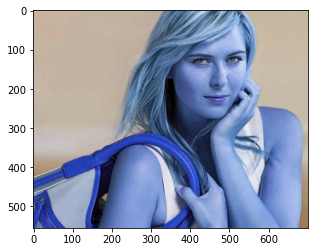

In [121]:
plt.imshow(img)

In [122]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(555, 700)

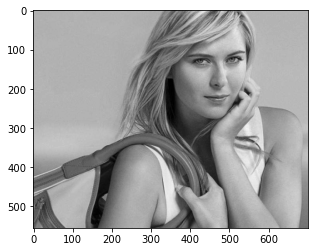

In [123]:
plt.imshow(gray, cmap='gray')

<h2>Face Detection</h2>

In [124]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')

In [125]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[352,  38, 233, 233]], dtype=int32)

In [126]:
x,y,w,h = faces[0]
x,y,w,h

(352, 38, 233, 233)

In [127]:
face_image = cv2.rectangle(img,(x,y),(x+w,y+h), (255,0,0), 2)

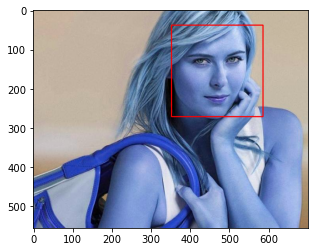

In [128]:
plt.imshow(face_image)

<h2>Eye Detection</h2>

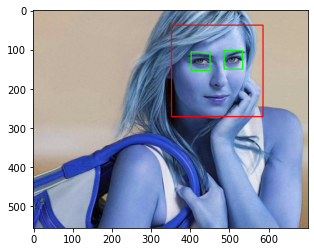

In [129]:
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_image = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_image[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex,ey), (ex+ew , ey+eh), (0,255,0), 2)

plt.figure()
plt.imshow(face_image, cmap='gray')
plt.show()

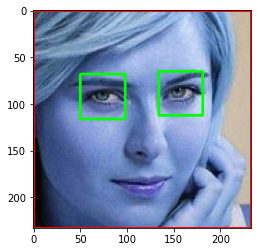

In [130]:
plt.imshow(roi_color, cmap='gray')

In [194]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    return_rois = []
    for x,y,w,h in faces:
#        face_image = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
#             for (ex, ey, ew, eh) in eyes:
#                 cv2.rectangle(roi_color, (ex,ey), (ex+ew , ey+eh), (0,255,0), 2)
            return_rois.append(roi_color)
    return return_rois  


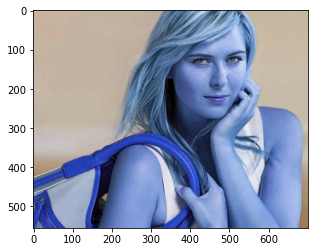

In [195]:
path = './datasets/maria_sharapova/sharapova-hits-the-practice-courts-and-met-ball-kids.jpg'
original_image = cv2.imread(path)

plt.imshow(original_image)

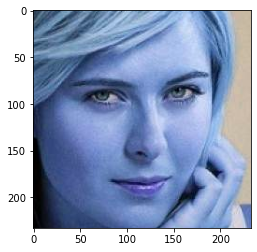

In [196]:
cropped_image = get_cropped_image_if_2_eyes(path)[0]
if cropped_image is not None:
    plt.imshow(cropped_image)

# Cropped Data Function

In [197]:
path_to_data = "./datasets/"
path_to_cr_data = "./datasets/cropped/"

In [198]:
import os
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [199]:
img_dirs = img_dirs[1:]

In [200]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [201]:
cropped_image_dir = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    celibrity_name = img_dir.split('/')[-1]
#     print(celibrity_name)
    celebrity_file_names_dict[celibrity_name] = []
    count = 0
    for entry in os.scandir(img_dir):
        
        if entry.is_dir():
            continue
        roi_colors = get_cropped_image_if_2_eyes(entry.path)
        
        for roi_color in roi_colors:
            count += 1
            cropped_folder = path_to_cr_data + celibrity_name

            if not os.path.exists(cropped_folder):
                cropped_image_dir.append(cropped_folder)
                os.makedirs(cropped_folder)

            cropped_file_name = celibrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path, roi_color)

            celebrity_file_names_dict[celibrity_name].append(cropped_file_path)

# Feature Engineering Wavelet Transformation


In [142]:
import numpy as np
import pywt
import cv2


In [143]:
def w2d(img, mode='haar', level = 1):
    imArray = img
    
    imArray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
    imArray = np.float32(imArray)
    imArray /= 255
    
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

In [169]:
im_har = w2d(cropped_image,'db1', 5             
            )

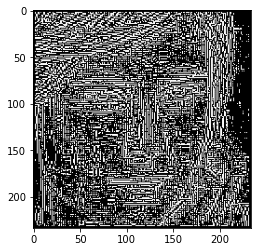

In [170]:
plt.imshow(im_har, cmap='gray')

In [171]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count += 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [172]:
X = []
y = []

for celibrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        try:
            img = cv2.imread(training_image)
            if img is None:
                continue
            scalled_raw_img = cv2.resize(img, (32,32))
            img_har = w2d(img, 'db1', 1)
            scalled_img_har = cv2.resize(img_har, (32,32))
            combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1), scalled_img_har.reshape(32*32,1)))
            X.append(combined_img)
            y.append(class_dict[celibrity_name])
            
        except Exception as e:
            print(training_image)
            print(str(e))
            




In [173]:
len(X[0])

4096

In [174]:
X = np.array(X).reshape(len(X),4096).astype(float)

# SVM


In [175]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [177]:
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.75

In [178]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.80      0.76        10
           1       0.53      0.89      0.67         9
           2       0.82      0.90      0.86        10
           3       1.00      0.47      0.64        15
           4       0.83      0.83      0.83        12

    accuracy                           0.75        56
   macro avg       0.78      0.78      0.75        56
weighted avg       0.81      0.75      0.75        56



# Grid Search CV


In [74]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [75]:
model_parms = {
    'svm' :{
        'model' : svm.SVC(gamma = 'auto', probability= True),
        'params' : {
            'svc__C' : [1,10,100,1000],
            'svc__kernel' : ['rbf', 'linear']
        }
    },
    'random_forest' : {
        'model': RandomForestClassifier(),
        'params':{
            'randomforestclassifier__n_estimators' : [1,5,10]
        }
        
    },
    'logistics_regression' : {
        'model' : LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
        'params': {
            'logisticregression__C' : [1,5,10]
        }
    }
}

In [76]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_parms.items():
    pipe = make_pipeline(StandardScaler(),mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score = False)
    clf.fit(X_train, y_train)
    scores.append({
        'model':algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores, columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.842769,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.669231,{'randomforestclassifier__n_estimators': 10}
2,logistics_regression,0.873846,{'logisticregression__C': 1}


In [77]:
best_estimators['svm'].score(X_test, y_test)

0.9302325581395349

In [78]:
best_estimators['random_forest'].score(X_test, y_test)

0.7209302325581395

In [79]:
best_estimators['logistics_regression'].score(X_test, y_test)

0.9069767441860465

In [80]:
best_clf = best_estimators['svm']

In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, best_clf.predict(X_test))

In [82]:
cm

array([[ 7,  1,  0,  2,  0],
       [ 0, 10,  0,  0,  0],
       [ 0,  0,  4,  0,  0],
       [ 0,  0,  0,  9,  0],
       [ 0,  0,  0,  0, 10]], dtype=int64)

Text(69.0, 0.5, 'Truth')

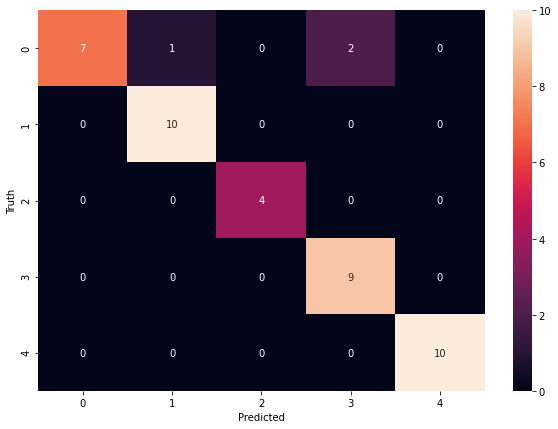

In [83]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm,annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [84]:
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

# Save the trained Model

In [85]:
import joblib

In [86]:
joblib.dump(best_clf, 'saved_model.pkl')

['saved_model.pkl']

In [87]:
import json

In [88]:
with open ('class_dictionary.json', 'w') as f:
    f.write(json.dumps(class_dict))